In [8]:
import re
import numpy as np
import pandas as pd
import pymssql
import openai
from langchain_groq import ChatGroq
from MilvusRetriever import MilvusRetriever
from dotenv import load_dotenv
import yaml
from datetime import datetime, date
from functools import lru_cache
import random
import uuid

import os
import json
import dateutil
import getpass
from typing import Annotated, Optional, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display


In [2]:
load_dotenv()

True

In [3]:
retriever = MilvusRetriever(documents=[],k=3)
retriever.init()   

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/fermikira/anaconda3/envs/llms_env/lib/python3.12/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_state_dict =

Loading existing collection: hybrid_rag


In [4]:
with open("config.yaml", 'r') as file:
        config = yaml.safe_load(file)
        database_config = config.get('database', {})
        user = database_config.get('username')
        password = database_config.get('password')


In [5]:
LOGUER = 'loguer'
PROCESSOR = 'processor'
VERIFIER = 'verifier'
ASSISTANT = 'assistant'
HIL = 'hil'
TOOLS = 'tools'

In [6]:
class RequiredInformation(BaseModel):
    provided_id: Optional[int] = Field(None,description="La cédula que proporcionó el usuario")
    provided_email: Optional[str] = Field(None,description="El email que proporcionó el usuario")

class State(TypedDict):
    user_question: str
    messages: Annotated[list[AnyMessage], add_messages]
    validated: bool
    required_information: RequiredInformation
    telefono : int

llm = ChatGroq(groq_api_key=os.environ['GROQ_API_KEY'], model_name="llama3-70b-8192")

In [7]:
system = """Eres un asistente auxiliar con la tarea de verificar la identidad del cliente.
            1. Primero necesitas recoger la información del cliente para poder verificarlo.
            2. Luego de que colectes toda la información, di amablemente gracias y que vas a pasar a verificarlo.
            
            La información a continuación es la que debes recolectar:

            class RequiredInformation(BaseModel):
                provided_id: Optional[int] = Field(None,description="La cédula que proporcionó el usuario")
                provided_email: Optional[str] = Field(None,description="El email que proporcionó el usuario")
                
            Asegurate de tener la información antes de que puedas proceder, pero recolectala un campo a la vez. 
            Si el usuario se equivocó ingresando los datos, por favor dile porqué y que vuelva a ingresar el dato.
            Si alguna de esta información no es proporcionada retorna None

            NO LLENES LA INFORMACIÓN DEL USUARIO, RECOLECTALA.
            """
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "User question: {user_question}"
            "Chat history: {messages}"
            "Telefono:{telefono}"
            "\n\n What the user have provided so far {provided_required_information} \n\n",
        ),
    ]
)

def assistant_node(state: State) -> dict:
    print("En el logueador", state)
    get_information_chain = assistant_prompt | llm.bind_tools([RequiredInformation])
    res = get_information_chain.invoke(
        {
            "user_question":state["user_question"] if "user_question" in state else None,
            "provided_required_information": state["required_information"] if "required_information" in state else None,
            "messages": state["messages"] if "messages" in state else [],
            "telefono": state["telefono"]
        }
    )
    return {"user_question":state["messages"][-1].content,"messages": [res]}

def combine_required_info(info_list: list[RequiredInformation]) -> RequiredInformation:
    print("Combinando información requerida...")
    info_list = [info for info in info_list if info is not None]

    if len(info_list) == 1:
        return info_list[0]
    combined_info = {}
    for info in info_list:
        for key, value in info.model_dump().items():
            if value is not None:
                combined_info[key] = value
    print(combined_info)
    return RequiredInformation(**combined_info)


def process_info(state: State) -> dict:
    print("procesando información ingresada por el usuario:", state)
    structured_llm_user_info = llm.with_structured_output(RequiredInformation)

    information_chain = assistant_prompt | structured_llm_user_info
    res = information_chain.invoke(
        {
            "user_question": state["user_question"],
            "provided_required_information": state["user_question"],
            "messages": state["messages"],
            "telefono": state["telefono"]
        }
    )
    if "required_information" in state:
        required_info = combine_required_info(
            info_list=[res, state.get("required_information")]
        )
    else:
        required_info = res
    return {
        "required_information": required_info,
        "messages": [HumanMessage(content=state["user_question"])],
    }
    

def verify_information(state: State) -> dict:
    print("Verificando...")
    Telefono = state["telefono"]
    required_information: RequiredInformation = state["required_information"]

    cnxn = pymssql.connect(server='192.168.50.38\\DW_FZ', database='DW_FZ', user=user, password=password)
    query4 = f"""
        SELECT * FROM [DW_FZ].[dbo].[CRM_Datos_Cliente] Where Telefono = '{Telefono}';
        """
    df_cl = pd.read_sql_query(query4, cnxn)
    
    if not df_cl.empty:
        correo_cl = df_cl['Correo']
        cedula_cl = df_cl['Cedula']
        if required_information.provided_id == cedula_cl.values[0] and required_information.provided_email == correo_cl.values[0]:
            print("Verificado!!!")
            return {"validated": True}
        else:
            return {"validated": False}          
    else: 
        return {"validated": False}
    

def provided_all_details(state: State) -> str:
    print("Mirando si ya ingresó toda la info")
    if "required_information" not in state:
        print("No ha recolectado ninguna info todavía")
        return "need to collect more information"
    provided_information: RequiredInformation = state["required_information"]
    if (
        provided_information.provided_id
        and provided_information.provided_email
    ):
        print("Ya ingresó toda la info")
        return "all information collected"
    else:
        print("No ha recolectado TODA la info")
        return "need to collect more information"


def verified(state: State) -> str:
    print("En la arista de verificación")
    verified_successfully = state["validated"]

    if verified_successfully:
        return "agent_with_tools"
    else:
        return ASSISTANT
    
def get_state(state) -> Literal["loguer","add_tool_msg", "__end__"]:
    print("ON EDGE: GET STATE")
    messages = state["messages"]
    print(messages[-1])
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        print("NEXT NODE: TOOL MESSAGE")
        return "add_tool_msg"
    elif not isinstance(messages[-1], HumanMessage):
        print("NEXT NODE: HUMAN RESPONSE (END)")
        return END
    else:
        return 'loguer'

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )
    

In [8]:
@tool
def lookup_questions(query : str) -> str:
    """
    Consulta la base de datos de documentos para resolver la pregunta del cliente
    """
    docs = retriever.invoke(query)
    return docs

In [9]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State):
        print("En el asistente!!!")
        while True:
            result = self.runnable.invoke(
                    {
                        "user_question":state["messages"][-1],
                        "messages": state["messages"] if "messages" in state else [],
                        "telefono": state["telefono"]
                    }
                )
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Responde con un output real")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}
    
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Eres SAC, el agente de servicio al cliente más eficiente de Finanzauto en Colombia."
            "Usa las herramintas otorgadas para responder a las preguntas del usuario, mostrar creditos, etc."
            "RESPONDE SIEMPRE EN ESPAÑOL"
            "\n\nteléfono del usuario actual:\n<User>\n{telefono}\n</User>"
            "\nTiempo actual: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    lookup_questions
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [10]:
workflow = StateGraph(State)
workflow.add_node(LOGUER, assistant_node)
workflow.add_node(PROCESSOR, process_info)
workflow.add_node(VERIFIER, verify_information)
workflow.add_node(ASSISTANT, Assistant(part_1_assistant_runnable))
workflow.add_node(TOOLS, create_tool_node_with_fallback(part_1_tools))

workflow.set_entry_point(LOGUER)
workflow.add_conditional_edges(
    LOGUER,
    get_state
    {
        "__end__",
        "processor"
    }
)
#workflow.add_edge(LOGUER, HIL)
#workflow.add_edge(HIL, PROCESSOR)
workflow.add_conditional_edges(
    PROCESSOR,
    provided_all_details,
    {
        "need to collect more information": LOGUER,
        "all information collected": VERIFIER,
    },
)
workflow.add_conditional_edges(
    VERIFIER,
    verified,
    {"agent_with_tools": ASSISTANT, LOGUER: LOGUER},
)


# Define edges: these determine how the control flow moves

workflow.add_conditional_edges(
    ASSISTANT,
    tools_condition,
    {
        TOOLS:TOOLS,
        '__end__':END
    }
)
workflow.add_edge(TOOLS, ASSISTANT)

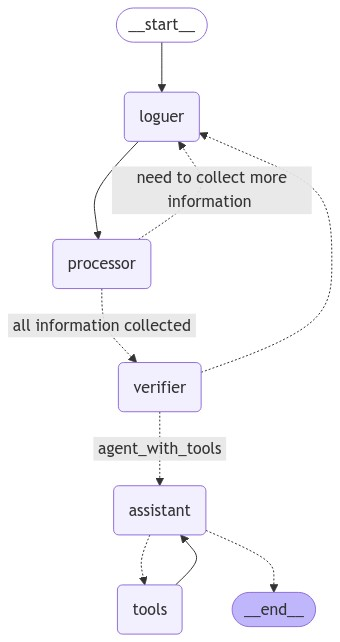

In [11]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
graph.get_graph().draw_mermaid_png(output_file_path="graph.png")
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"messages":['Hola, soy Daniel'], "telefono":"3152332041"},config=config)

KeyError: 'thread_id'

In [12]:
thread_id = 1

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}

In [ ]:
graph.invoke({"messages":['Hola, soy Daniel'], "telefono":"3152332041"}, config)

En el logueador {'user_question': 'Hola, doy Daniel', 'messages': [HumanMessage(content='Hola, soy Daniel', additional_kwargs={}, response_metadata={}, id='55b17028-e283-4ed4-a1f9-6bf79660f5b9'), HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='f00ac5ce-af6d-4566-b23c-041984c0817f'), HumanMessage(content='juanfonsecagaravito@gmail.com', additional_kwargs={}, response_metadata={}, id='944c2640-cbda-4ff7-8740-80095a1f9228'), HumanMessage(content='cual es la sede de medellín?', additional_kwargs={}, response_metadata={}, id='e930c33f-1790-4047-b59c-dbc63032cc05'), AIMessage(content='Hola Daniel, necesito verificar su identidad para proseguir. Para hacerlo, necesito algunos datos suyos. Por favor, proporcione su cédula de identidad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 426, 'total_tokens': 466, 'completion_time': 0.128849125, 'prompt_time': 0.02632654, 'queue_time': 0.00428417, 'total_time': 0.155

/tmp/ipykernel_502465/4025079817.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


Verificado!!!
En la arista de verificación
En el asistente!!!


In [14]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'user_question': 'cual es la sede de medellín?', 'messages': [HumanMessage(content='Hola, soy Daniel', additional_kwargs={}, response_metadata={}, id='55b17028-e283-4ed4-a1f9-6bf79660f5b9'), HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='f00ac5ce-af6d-4566-b23c-041984c0817f'), HumanMessage(content='juanfonsecagaravito@gmail.com', additional_kwargs={}, response_metadata={}, id='944c2640-cbda-4ff7-8740-80095a1f9228'), HumanMessage(content='cual es la sede de medellín?', additional_kwargs={}, response_metadata={}, id='e930c33f-1790-4047-b59c-dbc63032cc05'), AIMessage(content='Hola Daniel, necesito verificar su identidad para proseguir. Para hacerlo, necesito algunos datos suyos. Por favor, proporcione su cédula de identidad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 426, 'total_tokens': 466, 'completion_time': 0.128849125, 'prompt_time': 0.02632654, 'queue_time': 0.00428417, 't

In [15]:
graph.invoke({"messages":'125748', "telefono":"3152332041"}, config)

En el logueador {'user_question': 'cual es la sede de medellín?', 'messages': [HumanMessage(content='Hola, soy Daniel', additional_kwargs={}, response_metadata={}, id='55b17028-e283-4ed4-a1f9-6bf79660f5b9'), HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='f00ac5ce-af6d-4566-b23c-041984c0817f'), HumanMessage(content='juanfonsecagaravito@gmail.com', additional_kwargs={}, response_metadata={}, id='944c2640-cbda-4ff7-8740-80095a1f9228'), HumanMessage(content='cual es la sede de medellín?', additional_kwargs={}, response_metadata={}, id='e930c33f-1790-4047-b59c-dbc63032cc05'), AIMessage(content='Hola Daniel, necesito verificar su identidad para proseguir. Para hacerlo, necesito algunos datos suyos. Por favor, proporcione su cédula de identidad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 426, 'total_tokens': 466, 'completion_time': 0.128849125, 'prompt_time': 0.02632654, 'queue_time': 0.00428417, 'total_

/tmp/ipykernel_502465/4025079817.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


Verificado!!!
En la arista de verificación
En el asistente!!!


{'user_question': '125748',
 'messages': [HumanMessage(content='Hola, soy Daniel', additional_kwargs={}, response_metadata={}, id='55b17028-e283-4ed4-a1f9-6bf79660f5b9'),
  HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='f00ac5ce-af6d-4566-b23c-041984c0817f'),
  HumanMessage(content='juanfonsecagaravito@gmail.com', additional_kwargs={}, response_metadata={}, id='944c2640-cbda-4ff7-8740-80095a1f9228'),
  HumanMessage(content='cual es la sede de medellín?', additional_kwargs={}, response_metadata={}, id='e930c33f-1790-4047-b59c-dbc63032cc05'),
  AIMessage(content='Hola Daniel, necesito verificar su identidad para proseguir. Para hacerlo, necesito algunos datos suyos. Por favor, proporcione su cédula de identidad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 426, 'total_tokens': 466, 'completion_time': 0.128849125, 'prompt_time': 0.02632654, 'queue_time': 0.00428417, 'total_time': 0.155175665}, 'model_n

In [16]:
thread_id = 1

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}
for event in graph.stream({"messages":'Hola, doy Daniel', "telefono":"3152332041"}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hola, doy Daniel
En el logueador {'user_question': '125748', 'messages': [HumanMessage(content='Hola, soy Daniel', additional_kwargs={}, response_metadata={}, id='55b17028-e283-4ed4-a1f9-6bf79660f5b9'), HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='f00ac5ce-af6d-4566-b23c-041984c0817f'), HumanMessage(content='juanfonsecagaravito@gmail.com', additional_kwargs={}, response_metadata={}, id='944c2640-cbda-4ff7-8740-80095a1f9228'), HumanMessage(content='cual es la sede de medellín?', additional_kwargs={}, response_metadata={}, id='e930c33f-1790-4047-b59c-dbc63032cc05'), AIMessage(content='Hola Daniel, necesito verificar su identidad para proseguir. Para hacerlo, necesito algunos datos suyos. Por favor, proporcione su cédula de identidad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 426, 'total_tokens': 466, 'completion_tim

/tmp/ipykernel_502465/4025079817.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


Verificado!!!
En la arista de verificación
================================ Human Message =================================

Hola, doy Daniel
En el asistente!!!
================================== Ai Message ==================================

Hola Daniel, ya he verificado su identidad. ¿En qué puedo ayudarlo hoy? ¿Tiene alguna pregunta o consulta sobre su crédito o algún otro tema relacionado con Finanzauto?


In [14]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    async for output in graph.astream(
        {"messages": [HumanMessage(content=user)],"telefono":"3152332041"}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        print(last_message)
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): Hoola!
En el logueador {'messages': [HumanMessage(content='Hoola!', additional_kwargs={}, response_metadata={}, id='4dddca9d-761e-459f-a50f-d3498431c962')], 'telefono': '3152332041'}
content='Bienvenido! Para verificar su identidad, necesito algunos datos. Por favor, proporcione su cédula (número de identificación).' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 296, 'total_tokens': 329, 'completion_time': 0.107108215, 'prompt_time': 0.019666914, 'queue_time': 0.006313993, 'total_time': 0.126775129}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_reason': 'stop', 'logprobs': None} id='run-7fada5d6-9ea2-4159-a903-6fd33d186682-0' usage_metadata={'input_tokens': 296, 'output_tokens': 33, 'total_tokens': 329}
================================== Ai Message ==================================

Bienvenido! Para verificar su identidad, necesito algunos datos. Por favor, proporcione su cédula 

CancelledError: 

In [17]:
graph.update_state(config, {"messages": '125748', "telefono":"3152332041"}, as_node=HIL)

InvalidUpdateError: Node hil does not exist

In [14]:
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

125748
procesando información ingresada por el usuario: {'user_question': 'Hola, doy Daniel', 'messages': [HumanMessage(content='Hola, doy Daniel', additional_kwargs={}, response_metadata={}, id='17f88bb0-db1a-45d1-ba09-adb4bbe2220c'), AIMessage(content='¡Hola Daniel! Estoy aquí para ayudarte. Para verificar tu identidad, necesito algunos datos tuyos. Por favor, ¿puedes proporcionarme la cédula que tienes?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 301, 'total_tokens': 342, 'completion_time': 0.128116556, 'prompt_time': 0.02318909, 'queue_time': 0.03260847, 'total_time': 0.151305646}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-6cb8e32d-7c3b-4d02-9345-546f0a253f04-0', usage_metadata={'input_tokens': 301, 'output_tokens': 41, 'total_tokens': 342}), HumanMessage(content='

/tmp/ipykernel_499976/1338883911.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


In [15]:
graph.update_state(config, {"messages":'juanfonsecagaravito@gmail.com', "telefono":"3152332041"})

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7c0d2-5d66-623a-8005-eb5800ba35e9'}}

In [16]:
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

juanfonsecagaravito@gmail.com
Verificando...


/tmp/ipykernel_499976/1338883911.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


In [17]:
graph.get_state(config=config)

StateSnapshot(values={'user_question': 'Hola, doy Daniel', 'messages': [HumanMessage(content='Hola, doy Daniel', additional_kwargs={}, response_metadata={}, id='17f88bb0-db1a-45d1-ba09-adb4bbe2220c'), AIMessage(content='¡Hola Daniel! Estoy aquí para ayudarte. Para verificar tu identidad, necesito algunos datos tuyos. Por favor, ¿puedes proporcionarme la cédula que tienes?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 301, 'total_tokens': 342, 'completion_time': 0.128116556, 'prompt_time': 0.02318909, 'queue_time': 0.03260847, 'total_time': 0.151305646}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-6cb8e32d-7c3b-4d02-9345-546f0a253f04-0', usage_metadata={'input_tokens': 301, 'output_tokens': 41, 'total_tokens': 342}), HumanMessage(content='125748', additional_kwargs={}, response_metadata={}, id='95e76e40-7938-4bad-9b29-2b604ee8e8cc'), HumanMessage(content

In [18]:
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

juanfonsecagaravito@gmail.com
Verificando...


/tmp/ipykernel_499976/1338883911.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


In [19]:
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

juanfonsecagaravito@gmail.com
Verificando...


/tmp/ipykernel_499976/1338883911.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


In [20]:
for event in graph.stream({"messages": ['donde queda finanzauto?'], "telefono":"3152332041"}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

donde queda finanzauto?
En el logueador {'user_question': 'Hola, doy Daniel', 'messages': [HumanMessage(content='Hola, doy Daniel', additional_kwargs={}, response_metadata={}, id='17f88bb0-db1a-45d1-ba09-adb4bbe2220c'), AIMessage(content='¡Hola Daniel! Estoy aquí para ayudarte. Para verificar tu identidad, necesito algunos datos tuyos. Por favor, ¿puedes proporcionarme la cédula que tienes?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 301, 'total_tokens': 342, 'completion_time': 0.128116556, 'prompt_time': 0.02318909, 'queue_time': 0.03260847, 'total_time': 0.151305646}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id='run-6cb8e32d-7c3b-4d02-9345-546f0a253f04-0', usage_metadata={'input_tokens': 301, 'output_tokens': 41, 'total_tokens': 342}), HumanMessage(content='125748', additio

/tmp/ipykernel_499976/1338883911.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cl = pd.read_sql_query(query4, cnxn)


In [21]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [22]:
# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hola mi nombre es Daniel",
    "125748",
    "juanfonsecagaravito@gmail.com",
    "dame todas las sedes de finanzauto"
]

# Update with the backup file so we can restart from the original place in each section
thread_id = 2

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": question, "telefono":"3152332041"}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hola mi nombre es Daniel
En el logueador {'messages': [HumanMessage(content='Hola mi nombre es Daniel', additional_kwargs={}, response_metadata={}, id='6f3f15f8-1696-47af-a88d-e1205b940925')], 'telefono': '3152332041'}
================================== Ai Message ==================================

Hola Daniel, gracias por contactarnos. Para verificar tu identidad, necesito recopilar algunos datos. Por favor, ¿puedes proporcionarme la cédula que tienes registrada con nosotros?
================================ Human Message =================================

125748
En el logueador {'user_question': 'Hola mi nombre es Daniel', 'messages': [HumanMessage(content='Hola mi nombre es Daniel', additional_kwargs={}, response_metadata={}, id='6f3f15f8-1696-47af-a88d-e1205b940925'), AIMessage(content='Hola Daniel, gracias por contactarnos. Para verificar tu identidad, necesito recopilar algunos datos. Por favor, ¿p